# Overall

In order to train the SinVAR, normally, it includes to train the VAE first. However, given the time-horizon for the current project, 
and to stay with the original VAR paper, I will use the pretrained VQVAE as they have used. However, I will look into fine-tune the VQVAE if possible. 

Then, after the VQVAE, we have to train the VAR.

In [1]:
import numpy as np
import torch
import torch.nn as nn
from typing import Tuple

In [2]:
from vqvae import VQVAE
from var import VAR


def build_vae_var(
        # Shared args
        device, patch_nums=(1, 2, 3, 4, 5, 6, 8, 10, 13, 16),  # 10 steps by default
        # VQVAE args
        V=4096, Cvae=32, ch=160, share_quant_resi=4,
        # VAR args
        depth=16, attn_l2_norm=True,
        init_head=0.02, init_std=-1,  # init_std < 0: automated
) -> Tuple[VQVAE, VAR]:
    heads = depth
    width = depth * 64
    dpr = 0.1 * depth / 24

    # disable built-in initialization for speed
    for clz in (nn.Linear, nn.LayerNorm, nn.BatchNorm2d, nn.SyncBatchNorm, nn.Conv1d, nn.Conv2d, nn.ConvTranspose1d,
                nn.ConvTranspose2d):
        setattr(clz, 'reset_parameters', lambda self: None)

    # build models
    vae_local = VQVAE(vocab_size=V, z_channels=Cvae, ch=ch, test_mode=True, share_quant_resi=share_quant_resi,
                      v_patch_nums=patch_nums).to(device)
    var_wo_ddp = VAR(
        vae_local=vae_local,
        depth=depth, embed_dim=width, num_heads=heads, drop_rate=0., attn_drop_rate=0., drop_path_rate=dpr,
        norm_eps=1e-6,
        attn_l2_norm=attn_l2_norm,
        patch_nums=patch_nums,
    ).to(device)
    var_wo_ddp.init_weights(init_head=init_head, init_std=init_std)

    return vae_local, var_wo_ddp

## VQVAE

- Loading from the Hugging Face
- Trying to Reconstruct on Random Crop

In [3]:
vae_var_config = {
    # Shared
    "device": torch.device("mps" if torch.mps.is_available() else "cpu"),
    "patch_nums" : (1, 2, 3, 4, 5, 6, 8, 10, 13, 16),

    # VAR config (customizable for your setup)
    "depth": 4,  # VAR transformer depth
    "attn_l2_norm": True,  

    # Initialisation options (irrelevant for non-adaptive setup)
    "init_head": 0.02,
    "init_std": -1,  # Use default init scheme
}

In [4]:
vae_local, var_wo_ddp = build_vae_var(
    V=4096, Cvae=32, ch=160, share_quant_resi=4,  # hard-coded VQVAE hyperparameters
    device=vae_var_config['device'],
    depth=vae_var_config['depth'], attn_l2_norm=vae_var_config['attn_l2_norm'],
    init_head=vae_var_config['init_head'], init_std=vae_var_config['init_std'],
)


[constructor]  ==== UNCONDITIONAL VAR: using SelfAttnBlock (4 blocks, no class label) ====
    [VAR config ] embed_dim=256, num_heads=4, depth=4
    [drop ratios ] drop_rate=0.0, attn_drop_rate=0.0, drop_path_rate=0.0166667 (tensor([0.0000, 0.0056, 0.0111, 0.0167]))

[init_weights] VAR with init_std=0.0360844


In [18]:
# download checkpoint for VQVAE
import os
import os.path as osp

# Download from Hugging Face
hf_home = 'https://huggingface.co/FoundationVision/var/resolve/main'
vae_ckpt = 'vae_ch160v4096z32.pth'
local_path = './pretrained-models'
if not osp.exists(os.path.join(local_path, vae_ckpt)): os.system(f'wget {hf_home}/{vae_ckpt}')

# load checkpoints
vae_local.load_state_dict(torch.load(os.path.join(local_path, vae_ckpt), map_location='cpu'), strict=True)

<All keys matched successfully>

In [6]:
# print(f'[INIT][#para] ' + ', '.join([f'{k}={count_p(m)}' for k, m in (('VAE', vae_local), ('VAE.enc', vae_local.encoder), ('VAE.dec', vae_local.decoder), ('VAE.quant', vae_local.quantize))]))
# print(f'[INIT][#para] ' + ', '.join([f'{k}={count_p(m)}' for k, m in (('VAR', var_wo_ddp),)]) + '\n\n')

In [7]:
# Move it to mps for quicker inference
vae_local.to(torch.device('mps'))

device = next(vae_local.parameters()).device
print(f"Current Device: {device}")

Current Device: mps:0


## Data

In order to either test the loaded model or to train the var, we need to first have a dataset.

### `Dataset` Object

This is the dataset object. Note that this dataset only has one image.

Image dimension: height=3744, width=5616, channel=3
Image dtype: dtype=dtype('uint8')


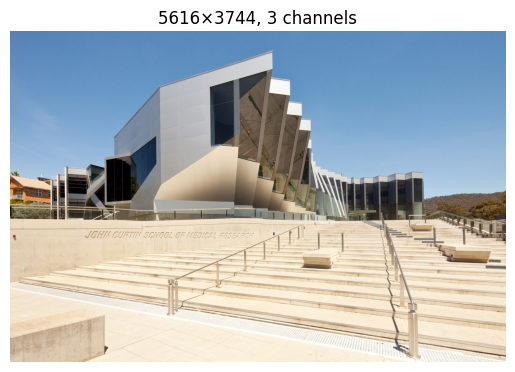

In [8]:
from skimage import io
import matplotlib.pyplot as plt
import numpy as np

image: np.ndarray = io.imread('./data/jcsmr.jpg')
height, width = image.shape[:2]
channel = image.shape[2] if image.ndim == 3 else 1
dtype = image.dtype

print(f"Image dimension: {height=}, {width=}, {channel=}")
print(f"Image dtype: {dtype=}")

plt.imshow(image)
plt.title(f"{width}×{height}, {channel} channels")
plt.axis("off")
plt.show()

In [9]:
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import v2

class SingleImageDataset(Dataset):
    """
    The single image dataset
    """
    def __init__(self, image_path, transform, seed, train=True):
        """
        This is the single Image dataset. Note that the single image dataset contains only one image. Therefore, it is important note that it is important to use random cropping and other
        transforming methods to augment the dataset.
        
        :param image_path: This is the path of the data.
        :param transform: Normally, this is optional. However, it is required for this dataset given that it has only one image. Also, please use some corpping.
        """
        self.image_path = image_path
        self.image = io.imread(image_path)
        self.transform = transform
        self.seed = seed
        self.train = train
    
    def __len__(self):
        return 10000 if self.train else 4285
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
            
        if isinstance(idx, list):
            return [self.__getitem__(i) for i in idx]
        
        if not isinstance(idx, int):
            raise TypeError(f"`idx` must be an integer or a list but got {type(idx)}")
        
        # Set deterministic augmentation for given idx
        torch.manual_seed(self.seed + idx) 
        return self.transform(self.image)    

### `Transform`

Then, we need to define the transform to use.

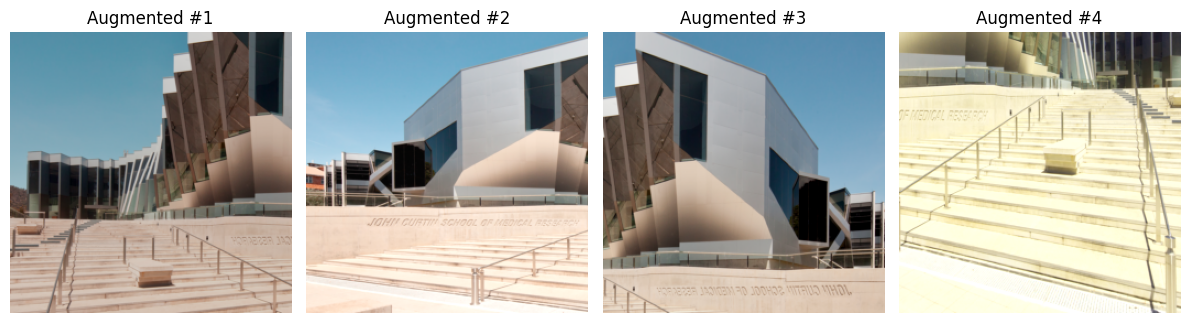

In [10]:
from torchvision.transforms.functional import to_pil_image

preview_transform = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.RandomResizedCrop(size=256, scale=(0.08, 0.5), ratio=(0.75, 2.0)),
    # v2.RandomPerspective(distortion_scale=0.3, p=0.5),    # This transformation causes unwanted padding, so I ended up disabling
    v2.RandomHorizontalFlip(p=0.5),
    # v2.RandomRotation(degrees=5),                         # This transformation causes unwanted padding, so I ended up disabling
    v2.ColorJitter(brightness=0.2, contrast=0.1, saturation=0.1, hue=0.05),
])

# Generate and display augmented images
plt.figure(figsize=(12, 4))
for i in range(4):
    aug = preview_transform(image)
    img_pil = to_pil_image(aug)
    plt.subplot(1, 4, i+1)
    plt.imshow(img_pil)
    plt.title(f'Augmented #{i+1}')
    plt.axis('off')

plt.tight_layout()
plt.show()


In [11]:
image_path = './data/jcsmr.jpg'
train_transform = v2.Compose([
    preview_transform,
    v2.Normalize(mean=[0.5]*3, std=[0.5]*3),
])
train_dataset = SingleImageDataset(image_path, transform=train_transform, seed=42)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

val_transform = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.RandomResizedCrop(size=256),
    v2.Normalize([0.5]*3, [0.5]*3),
])
val_dataset = SingleImageDataset(image_path, transform=val_transform, seed=1234567891, train=False)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)

test_transform = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.RandomResizedCrop(size=256),
])
test_dataset = SingleImageDataset(image_path, transform=test_transform, seed=9876543210, train=False)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)

## VQVAE Validation

First, I want to make sure that the VQVAE is reconstructing correctly.

4285


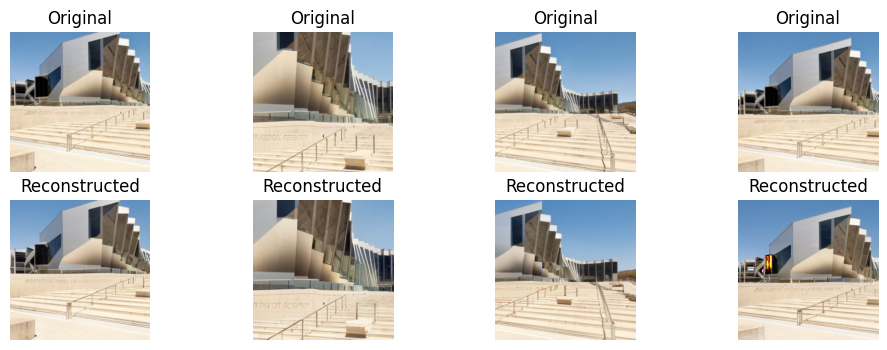

In [12]:
from torchvision.transforms.functional import normalize
def denorm(x: torch.Tensor):
    return normalize(x, mean=[-1]*3, std=[1/0.5]*3)
    
def show_vqvae_reconstruction(vae: VQVAE, dataloader, device, num_images=4):
    vae.eval()
    batch: torch.Tensor = next(iter(dataloader))[:num_images].to('cpu')
    # print(batch.shape)    # [B, C, H, W] as expected
    
    vae_cpu = vae_local.to('cpu').eval()
    
    with torch.no_grad():
        recon = vae_cpu.img_to_reconstructed_img(x=batch, last_one=True)
        # recon = vae.img_to_reconstructed_img(x=batch, last_one=True)

    # --- Visualization --- #
    plt.figure(figsize=(12, 4))
    for i in range(batch.shape[0]):
        # Original
        plt.subplot(2, batch.shape[0], i + 1)
        plt.imshow(to_pil_image((batch[i].cpu())))
        plt.title("Original")
        plt.axis("off")

        # Reconstructed
        plt.subplot(2, batch.shape[0], i + 1 + batch.shape[0])
        plt.imshow(to_pil_image((recon[i].cpu())))
        plt.title("Reconstructed")
        plt.axis("off")    

print(len(test_dataset)) 
show_vqvae_reconstruction(vae_local, test_loader, vae_var_config['device'], num_images=4) 

✅ Image downloaded and saved as 'imagenet_sample.jpg'


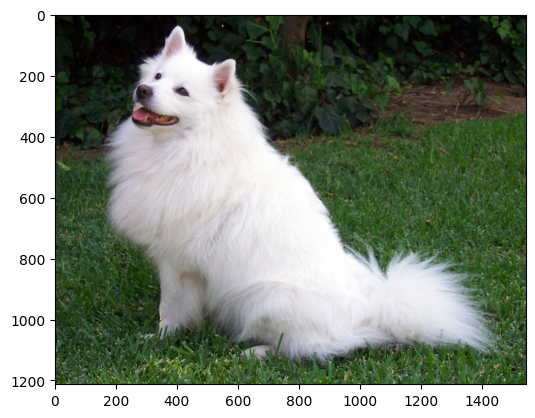

In [13]:
import requests
from PIL import Image
from io import BytesIO

# URL of an ImageNet sample image (Labrador Retriever)
img_url = "https://raw.githubusercontent.com/pytorch/hub/master/images/dog.jpg"
filename = "imagenet_sample.jpg"  # Save as this filename

# Download and save
response = requests.get(img_url)
img = Image.open(BytesIO(response.content)).convert("RGB")
img.save(filename)

print(f"✅ Image downloaded and saved as '{filename}'")

plt.imshow(img)

In [14]:
img_tensor: torch.Tensor = test_transform(img).unsqueeze(0).to("cpu")  # [1, 3, 256, 256]
img_tensor.shape, img_tensor.device

(torch.Size([1, 3, 256, 256]), device(type='cpu'))

(-0.5, 255.5, 255.5, -0.5)

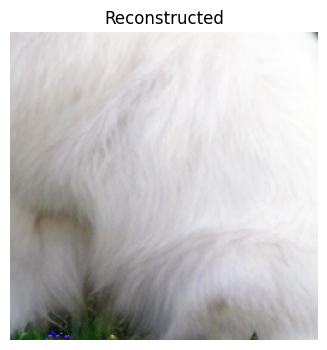

In [15]:
vae_cpu = vae_local.to('cpu').eval()

with torch.no_grad():
    recon = vae_cpu.img_to_reconstructed_img(x=img_tensor, last_one=True)

# --- Visualization --- #
plt.figure(figsize=(12, 4))
# Original
plt.imshow(to_pil_image((img_tensor[0].cpu())))
plt.title("Original")
plt.axis("off")

# Reconstructed
plt.imshow(to_pil_image((recon[0].cpu())))
plt.title("Reconstructed")
plt.axis("off")    

# VAR Training

Now, given that most of the VQVAE part are working correctly, we will proceed to training the VAR model.